In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR

def svr_volatility(df):
    """
    Calculates SVR volatility forecasts for a given DataFrame.

    Args:
        df (pandas.DataFrame): A DataFrame containing the time series of volatility.

    Returns:
        A list of predicted volatilities for the test set.
    """
    volatility = list(df["volatility"])

    train_volatility = volatility[:round(len(volatility)*0.8)]
    test_volatility = volatility[round(len(volatility)*0.8):]

    # Initialize SVR model with default parameters
    model = SVR()

    # Loop through the test set
    predicted_volatility = []
    for i in range(len(test_volatility)):
        # Add current test point to training data
        train_volatility = np.append(train_volatility, test_volatility[i])

        # Fit SVR model to updated training data
        X_train = np.arange(len(train_volatility)).reshape(-1, 1)
        y_train = np.array(train_volatility)
        model.fit(X_train, y_train)

        # Get the last value of the forecasted variance as the forecasted volatility
        forecasted_volatility = model.predict(np.array([[len(train_volatility)-1]]))

        # Append forecasted value to list of predicted volatilities
        predicted_volatility.append(forecasted_volatility)

    return predicted_volatility

def svr_each_stock(stock):
    """
    Calculates SVR volatility forecasts for each stock in a given DataFrame.

    Args:
        stock (pandas.DataFrame): A DataFrame containing the stock prices and volatilities.

    Returns:
        A list of predicted volatilities for all stocks.
    """
    # Get a list of unique time ids
    time_ids = stock['time_id'].unique()

    # Loop through the unique time ids
    first = True
    for time_id in time_ids:
        time_id_rows = stock[stock['time_id'] == time_id]

        if first == True:
            ls = svr_volatility(time_id_rows)
            first = False
        else:
            ls.extend(svr_volatility(time_id_rows))

    return ls


# Test the functions using the sample data frame - from Cecilia
df = pd.DataFrame({"time_id":[1, 1, 1,1, 1, 1,1,1,1,1,2,2,2,2,2,2,2],
                    "volatility":[5, 6, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21]})

In [266]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
# import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
# from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')




In [279]:
# Code to calculate Weighted Average Price for a Stock at a time.
def add_wap(stock1):
    stock1["WAP"] = (stock1["bid_price1"] * stock1["ask_size1"] + stock1["ask_price1"] * stock1["bid_size1"]) / (stock1["bid_size1"] + stock1["ask_size1"])
    return stock1

def calc_log_returns(stock1):
    # Creating empty list to store the log returns for each time period.
    log_r1 = []
    # Getting an array of unique time IDs from teh first column of the dataframe (is this the index assigned automatically?)
    time_IDs = np.unique(stock1.iloc[:, 0])

    # For every unique time id
    for i in range(len(time_IDs)):
        
        # Calculating the seconds in bucket and WAP values for rows where the time ID matches the current ID. 
        sec = stock1.loc[stock1.iloc[:, 0] == time_IDs[i], 'seconds_in_bucket'].values
        price = stock1.loc[stock1.iloc[:, 0] == time_IDs[i], 'WAP'].values

        # Calculating the log returns for this time period
        log_r = np.log(price[1:] / price[0:(len(price) - 1)])
        
        # Adding the log returns for this time period to the list. 
        log_r1.append(pd.DataFrame({'time': sec[1:], 'log_return': log_r}))
        # Check if any time periods were skipped.
        time_no_change = np.setdiff1d(np.arange(1, 601), log_r1[i]['time'].values)
        # Anytime periods that were skipped set them to have a log return of 0
        if len(time_no_change) > 0:
            new_df = pd.DataFrame({'time': time_no_change, 'log_return': 0})
            log_r1[i] = pd.concat([log_r1[i], new_df])
            log_r1[i] = log_r1[i].sort_values(by='time')

    return log_r1

# Function to compute the volatility from the log returns. 
def comp_vol(x):
    return np.sqrt(np.sum(x ** 2))

def calc_volatility(log_r1, sec):
    # List to store the volatility values for each time period. 
    vol = []
# For every time period
    for i in range(len(log_r1)):
        # We assign each log return to a time bucket (group of 30 seconds)
        log_r1[i]['time_bucket'] = np.ceil(log_r1[i]['time'] / sec)
        # Compute the volatility for each time bucket using the comp_vol function.
        vol.append(log_r1[i].groupby('time_bucket')['log_return'].agg(comp_vol).reset_index())
        vol[i].columns = ['time_bucket', 'volatility']
    
    return vol



In [280]:
stock = pd.read_csv('../individual_book_train/stock_13.csv')

stock = add_wap(stock)
log_returns = calc_log_returns(stock)
vol = calc_volatility(log_returns, 1)

In [281]:
log_returns[1]
#vol[1]

,time,log_return,time_bucket
0,1,0.000000e+00,1.0
0,2,-2.787352e-06,2.0
1,3,-2.130993e-04,3.0
2,4,5.825145e-05,4.0
3,5,3.914408e-05,5.0
...,...,...,...
250,596,0.000000e+00,596.0
251,597,-5.270847e-07,597.0
252,598,5.270847e-07,598.0
345,599,0.000000e+00,599.0


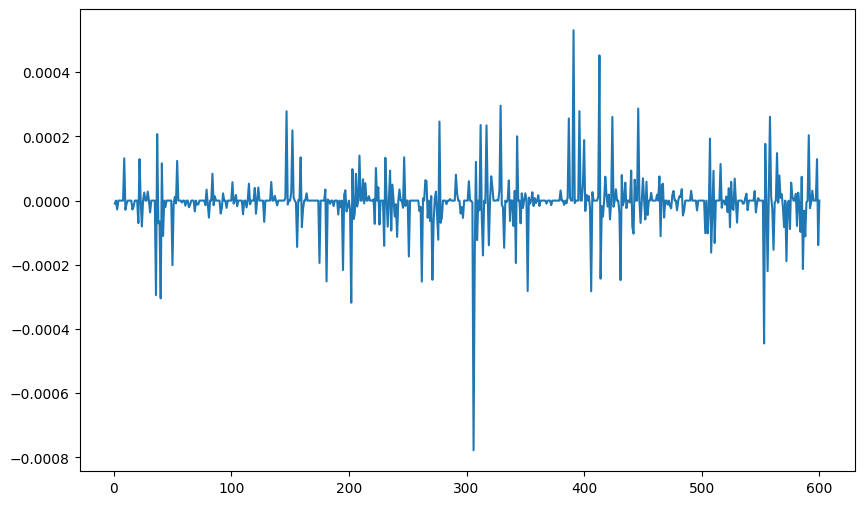

In [282]:
log_returns[1]

def plot_log_r(df):
    plt.figure(figsize=(10,6))
    plt.plot(df.time,df.log_return)
    plt.show

plot_log_r(log_returns[2])

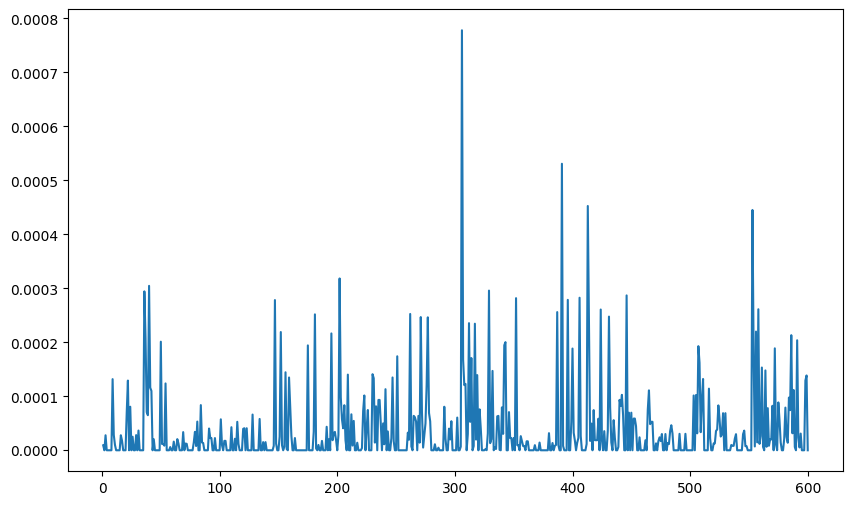

In [283]:
def plot_vol(df):
    plt.figure(figsize=(10,6))
    plt.plot(df.time_bucket,df.volatility)
    plt.show

plot_vol(vol[2])

Iteration:      1,   Func. Count:      5,   Neg. LLF: -4846.384059102394
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -4846.38405861441
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


/opt/homebrew/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


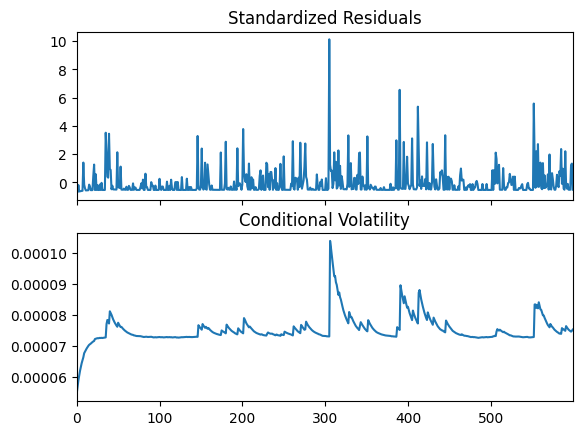

In [288]:
train_volatility = vol[2].volatility
model = arch_model(train_volatility, p=1, q=1)
fit_model = model.fit()

fit_model.plot()

my_vol = vol[2]

In [291]:
my_forecast = fit_model.forecast(horizon=1, start=400)
print(my_forecast.variance)

              h.1
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
..            ...
595  5.584022e-09
596  5.555915e-09
597  5.598774e-09
598  5.654667e-09
599  5.618789e-09

[600 rows x 1 columns]


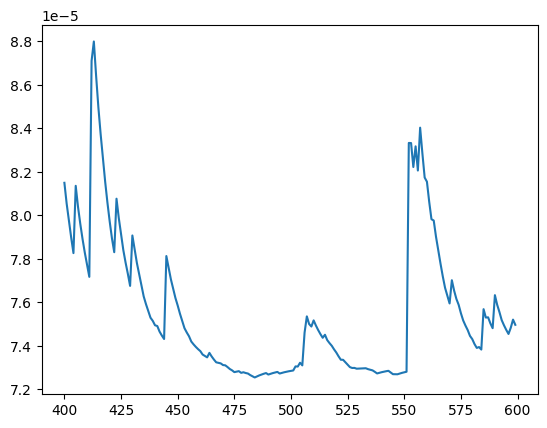

In [304]:
import numpy as np

predictions = my_forecast.variance.reset_index()
predictions = np.sqrt(predictions.drop(columns=['index']))
predictions

plt.plot(predictions, label='predictions')

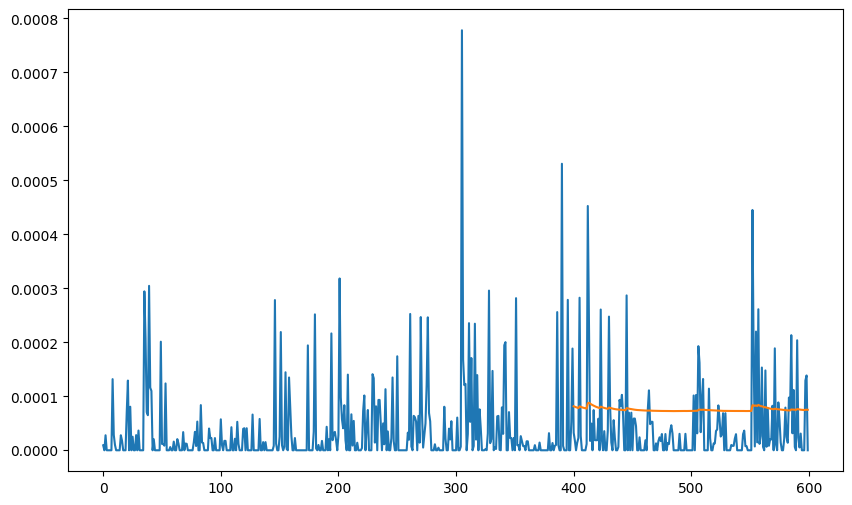

In [306]:
plt.figure(figsize=(10,6))
plt.plot((my_vol.volatility), label ='Realised Volatility')
plt.plot(((predictions)), label='predictions')

In [302]:
predictions[:-100]

,h.1
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
495,5.287967e-09
496,5.292426e-09
497,5.296395e-09
498,5.299927e-09


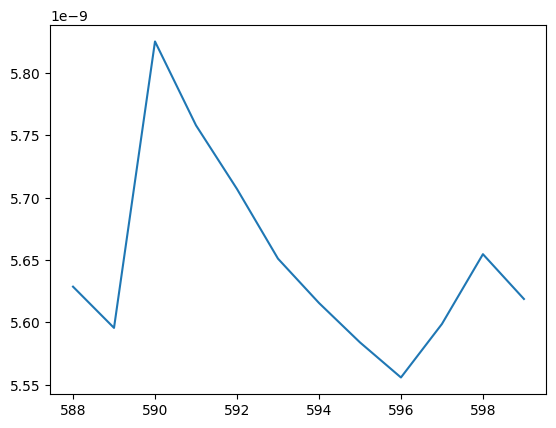

In [301]:
plt.plot(predictions[-12:])

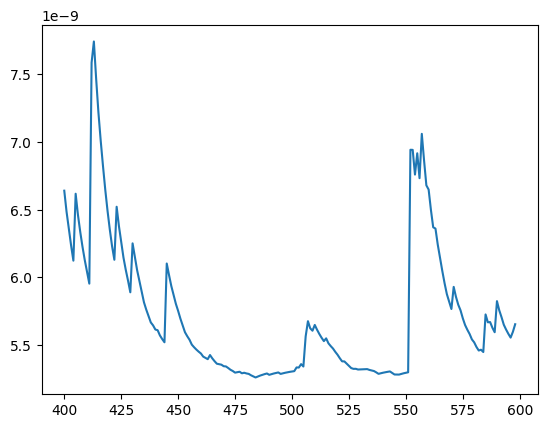

In [303]:
plt.plot((my_forecast.residual_variance[:-1]), label = "predictions")

In [76]:
# Getting optimum parameters.
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(df, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(log_returns[2].log_return, mean='zero', vol='GARCH',
                p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
print("best p: "+str(p))
print("best q: "+str(q))


                       Zero Mean - GARCH Model Results                        
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                4780.13
Distribution:                  Normal   AIC:                          -9554.26
Method:            Maximum Likelihood   BIC:                          -9541.07
                                        No. Observations:                  600
Date:                Sun, Apr 30 2023   Df Residuals:                      600
Time:                        17:54:28   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.4373e-10  3.441e-08  4.177e-03      0.997 

/opt/homebrew/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/lib/python3.9/site-package

You can't build Garch models off non-continuous time series data. All needs to be off the same continuous time period with the values taken at the same intervals.
Garch requiers data that has time series attached to it.

In [54]:
garch = arch_model(log_returns[2].log_return, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())


/opt/homebrew/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:            1.79126e+07
Distribution:                  Normal   AIC:                      -3.58251e+07
Method:            Maximum Likelihood   BIC:                      -3.58251e+07
                                        No. Observations:              2297400
Date:                Sun, Apr 30 2023   Df Residuals:                  2297400
Time:                        17:27:24   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.5502e-10  4.500e-10      1.011      0.312 

In [326]:
my_vol = my_vol.rename(columns={'time_bucket':'time_id'})
my_vol

,time_id,volatility
0,1.0,0.000009
1,2.0,0.000000
2,3.0,0.000028
3,4.0,0.000000
4,5.0,0.000000
...,...,...
595,596.0,0.000000
596,597.0,0.000000
597,598.0,0.000129
598,599.0,0.000139


In [359]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from tqdm import tqdm

def svr_volatility(df):

    volatility = list(df["volatility"])

    train_volatility = volatility[:round(len(volatility)*0.8)]
    test_volatility = volatility[round(len(volatility)*0.8):]

    # Initialize SVR model with default parameters
    model = SVR()

    # Loop through the test set
    predicted_volatility = []
    for i in range(len(test_volatility)):
        # Add current test point to training data
        train_volatility = np.append(train_volatility, test_volatility[i])

        # Fit SVR model to updated training data
        X_train = np.arange(len(train_volatility)).reshape(-1, 1)
        y_train = np.array(train_volatility)
        model.fit(X_train, y_train)

        # Get the last value of the forecasted variance as the forecasted volatility
        forecasted_volatility = model.predict(np.array([[len(train_volatility)-1]]))

        # Append forecasted value to list of predicted volatilities
        predicted_volatility.append(float(forecasted_volatility))
    
    # Return dataframe with predicted volatilities and corresponding time information
    time_df = df.iloc[round(len(volatility)*0.8):][["time_id", "time_bucket"]].reset_index(drop=True)
    time_df["predicted_volatility"] = pd.Series(predicted_volatility)

    return time_df

def run_svr(stock):
    
    # Get a list of unique time ids
    time_ids = stock['time_id'].unique()

    # Loop through the unique time ids
    results_df = pd.DataFrame(columns=["time_id","time_bucket","predicted_volatility"])

    # Loop through the unique time ids
    for time_id in tqdm(time_ids, desc="Processing time_ids"):  # wrap time_ids with tqdm()

        time_id_rows = stock[stock['time_id'] == time_id]
        
        # Check for missing values
        if time_id_rows['volatility'].isnull().sum() > 0:
            print(f"Missing values in volatility for time_id {time_id}")
            continue

        # Run GARCH model on the time_id rows and append the results to the results DataFrame
        svr_results = svr_volatility(time_id_rows)
        if svr_results is not None:
            results_df = pd.concat([results_df, svr_results], axis=0)
    
    merged_df = pd.merge(stock, results_df, on=['time_id', 'time_bucket'], how='outer')

    # Drop rows where predicted_volatility is NaN
    merged_df = merged_df.dropna(subset=['predicted_volatility'])

    return merged_df


# Test the functions using the sample data frame - from Cecilia
df = pd.DataFrame({"time_id":[1, 1, 1,1, 1, 1,1,1,1,1,2,2,2,2,2,2,2],
                   "time_bucket":[1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
                    "volatility":[5, 6, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21]})

data = pd.read_csv("../output.csv")
data = data[["time_id", "time_bucket", "volatility_stock_1"]]
data.columns = ["time_id", "time_bucket", "volatility"]

results = (run_svr(data))



Processing time_ids: 100%|██████████| 84/84 [00:02<00:00, 34.95it/s]


3.585714316678003e-07


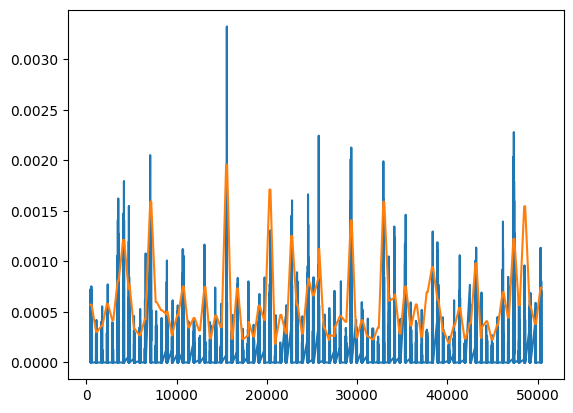

In [364]:
plt.plot(results.volatility)
plt.plot(results.predicted_volatility)

mse = np.mean((results.predicted_volatility - results.volatility)**2)
print(mse)

In [354]:
output = pd.read_csv("../output.csv")
output.head()



,time_id,time_bucket,volatility_stock_0,volatility_stock_1,volatility_stock_10,volatility_stock_100,volatility_stock_101,volatility_stock_102,volatility_stock_103,volatility_stock_104,...,volatility_stock_89,volatility_stock_9,volatility_stock_90,volatility_stock_93,volatility_stock_94,volatility_stock_95,volatility_stock_96,volatility_stock_97,volatility_stock_98,volatility_stock_99
0,5,1,0.000014,0.000247,0.000127,0.000000,0.000077,0.000000,0.000568,0.000003,...,0.001337,0.000000,0.0,2.694325e-04,0.000000,0.000046,0.000224,0.000032,0.00013,0.000091
1,5,2,0.000000,0.000252,0.000172,0.000000,0.000347,0.000001,0.000000,0.000000,...,0.000247,0.000105,0.0,1.317616e-04,0.000000,0.000027,0.000361,0.000324,0.00000,0.000166
2,5,3,0.000000,0.000630,0.000394,0.000000,0.000077,0.000004,0.000000,0.000000,...,0.000206,0.000027,0.0,6.205859e-05,0.000000,0.000053,0.000000,0.000297,0.00000,0.000004
3,5,4,0.000000,0.000295,0.000200,0.000047,0.000309,0.000000,0.000000,0.000066,...,0.000152,0.000400,0.0,9.815632e-07,0.000024,0.000154,0.000145,0.000289,0.00000,0.000091
4,5,5,0.000000,0.000269,0.000000,0.000056,0.000154,0.000000,0.000568,0.000759,...,0.000034,0.000000,0.0,0.000000e+00,0.000329,0.000038,0.000043,0.000280,0.00000,0.000013


In [347]:
# svr_each_stock(my_vol)
svr_results = svr_volatility(my_vol)
svr_results2 = svr_each_stock(my_vol)
print("Results")
print(svr_results)
plt.plot(svr_results2)

KeyError: "['time_bucket'] not in index"

In [321]:
my_vol

,time_bucket,volatility
0,1.0,0.000009
1,2.0,0.000000
2,3.0,0.000028
3,4.0,0.000000
4,5.0,0.000000
...,...,...
595,596.0,0.000000
596,597.0,0.000000
597,598.0,0.000129
598,599.0,0.000139


In [338]:
stock = pd.read_csv('../Optiver_additional_data/order_book_feature.csv')
stock

,stock_id\ttime_id\tseconds_in_bucket\tbid_price1\task_price1\tbid_price2\task_price2\tbid_size1\task_size1\tbid_size2\task_size2
0,8382\t12\t1.0\t722.1700000000002\t722.63\t722....
1,8382\t12\t2.0\t722.1800000000002\t722.88\t722....
2,8382\t12\t3.0\t722.33\t722.6500000000002\t722....
3,8382\t12\t4.0\t722.6800000000002\t722.98\t722....
4,8382\t12\t5.0\t722.52\t722.96\t722.42000000000...
...,...
17646114,104919\t1199\t1795.0\t364.14\t364.16\t364.13\t...
17646115,104919\t1199\t1796.0\t364.12\t364.14\t364.11\t...
17646116,104919\t1199\t1797.0\t364.13\t364.14\t364.12\t...
17646117,104919\t1199\t1798.0\t364.12\t364.13\t364.11\t...
